In [1]:
import os
import torch
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import grad
from torch.distributions import Categorical


from matplotlib import cm
from scipy.linalg import expm
from qutip import Bloch, Qobj

In [2]:
# Hyperparameters
LEARNING_RATE = 1e-4
GAMMA = 0.9
MEMORY_SIZE = 10000
BATCH_SIZE = 512
TARGET_UPDATE = 10
EPISODES = 200000
PATIENCE = EPISODES / 2
MAX_STEPS = 10
FIDELITY_THRESHOLD = 1e-5

# Define Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Define Hamiltonian parameters
omega = 1.0
J = 0.1

# Define Gates
HADAMARD = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
T_GATE = np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]], dtype=np.complex128)
CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

GPU Management

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [6]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)

__Python VERSION: 3.12.3 (main, Sep  4 2024, 12:08:24) [GCC 13.2.0]
__pyTorch VERSION: 2.4.1+cu124


In [7]:
print("__CUDA VERSION")
!nvidia-smi

__CUDA VERSION
Fri Sep 13 10:11:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   63C    P5              8W /   50W |      96MiB /   4096MiB |     38%      Default |
|                                         |                        |                  N/A |
+--------------------------------

In [8]:
print("__CUDNN VERSION:", torch.backends.cudnn.version())
!nvcc --version

__CUDNN VERSION: 90100
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Aug_14_10:10:22_PDT_2024
Cuda compilation tools, release 12.6, V12.6.68
Build cuda_12.6.r12.6/compiler.34714021_0


In [9]:
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Available devices ", torch.cuda.device_count())
print("Active CUDA Device: GPU", torch.cuda.current_device())

__Number CUDA Devices: 1
__Devices
Available devices  1
Active CUDA Device: GPU 0


In [10]:
class QuantumGateEnv:
    """
    A class to represent the environment for quantum gate control using reinforcement learning.

    Attributes:
    ----------
    gate : str
        The type of quantum gate (e.g., 'H', 'T', 'CNOT').
    control_pulse_params : dict
        Dictionary containing amplitude, phase, and duration parameters for control pulses.
    initial_state : np.ndarray
        The initial quantum state of the system.
    state : np.ndarray
        The current quantum state of the system.
    target : np.ndarray
        The target quantum gate matrix.
    theoretical_state : np.ndarray
        The expected quantum state after applying the target gate.
    time_step : int
        The current time step in the episode.
    max_steps : int
        The maximum number of steps in an episode.
    state_history : list
        A history of quantum states during an episode.
    """

    def __init__(self, gate):
        """
        Initializes the QuantumGateEnv with the specified gate type.

        Parameters:
        ----------
        gate : str
            The type of quantum gate (e.g., 'H', 'T', 'CNOT').
        """
        self.control_pulse_params = {
            "amplitude": np.linspace(0, 1, 12),  # Example amplitudes
            "phase": np.linspace(-np.pi, np.pi, 12),  # Example phases
            "duration": np.linspace(0.1, 1.0, 120),  # Example durations
        }
        self.gate = gate
        (
            self.initial_state,
            self.target_state,
            self.state_size,
            self.action_size,
            self.input_features,
            self.hidden_features,
        ) = self.set_quantum_info()
        self.reset()

    def set_quantum_info(self):
        """
        Sets the quantum information for the environment based on the gate type.

        Returns:
        -------
        tuple
            A tuple containing the initial state, target_state, state size, action size, and input features.
        """
        action_size = (
            len(self.control_pulse_params["amplitude"])
            * len(self.control_pulse_params["phase"])
            * len(self.control_pulse_params["duration"])
        )

        if self.gate in ["H", "T"]:
            num_qubits = 1
            state_size = 2**num_qubits
            initial_states = [
                np.array([1, 0], dtype=np.complex128),
                np.array([0, 1], dtype=np.complex128),
            ]
            initial_state = random.choice(initial_states)
            input_features = 2 ** (
                num_qubits + 1
            )  # Number of states in the input space
            hidden_features = 512
            unitary = HADAMARD if self.gate == "H" else T_GATE
            target_state = np.dot(initial_state, unitary)

        elif self.gate == "CNOT":
            num_qubits = 2
            state_size = 2**num_qubits
            initial_states = [
                np.array([1, 0, 0, 0], dtype=np.complex128),
                np.array([0, 1, 0, 0], dtype=np.complex128),
                np.array([0, 0, 1, 0], dtype=np.complex128),
                np.array([0, 0, 0, 1], dtype=np.complex128),
            ]
            initial_state = random.choice(initial_states)
            input_features = 2 ** (
                num_qubits + 1
            )  # Number of states in the input space
            hidden_features = 512
            unitary = CNOT
            target_state = np.dot(initial_state, unitary)

        return (
            initial_state,
            target_state,
            state_size,
            action_size,
            input_features,
            hidden_features,
        )

    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
        -------
        np.ndarray
            The initial quantum state.
        """
        self.state = self.initial_state.copy()
        self.time_step = 0
        self.max_steps = MAX_STEPS
        self.reward_episode = [-1]
        self.fidelity_episode = [0]
        self.state_episode = [self.state]
        self.amplitude_episode = [0]
        self.phase_episode = [0]
        self.duration_episode = [0]
        return self.state

    def _time_evolution_operator(self, H, t):
        """
        Compute the time evolution operator U(t) = exp(-i * H * t).

        Parameters:
        H (ndarray): The Hamiltonian matrix.
        t (float): The time over which to evolve the system.

        Returns:
        ndarray: The time evolution operator U(t).
        """
        return expm(-1j * H * t)

    def _construct_hamiltonian(self, amplitude, phase):
        """
        Constructs the Hamiltonian for the quantum gate operation based on the gate type.

        Parameters:
        ----------
        amplitude : float
            The amplitude of the control Hamiltonian, which modulates the strength of the control fields.
        phase : float
            The phase of the control Hamiltonian, which determines the direction of the control field in the XY-plane.

        Returns:
        -------
        H_total : ndarray
            The total Hamiltonian (system + control) for the specified gate operation.
            If the gate is "H" or "T", returns a 2x2 matrix.
            If the gate is "CNOT", returns a 4x4 matrix.
        """
        if self.gate in ["H", "T"]:
            H_sys = (omega / 2) * Z  # System Hamiltonian (static)
            H_control = amplitude * (
                np.cos(phase) * X + np.sin(phase) * Y
            )  # Control Hamiltonian (depends on amplitude and phase)
            return H_sys + H_control  # Total Hamiltonian
        elif self.gate == "CNOT":
            H_system = (
                (omega / 2) * np.kron(Z, I)
                + (omega / 2) * np.kron(I, Z)
                + J * (np.kron(X, X) + np.kron(Y, Y))
            )  # System Hamiltonian (static)
            H_control = amplitude * (
                np.kron(X, I) * np.cos(phase) + np.kron(Y, I) * np.sin(phase)
            )  # Control Hamiltonian (depends on amplitude and phase)
            return H_system + H_control  # Total Hamiltonian

    def infidelity(self, final_state):
        """
        Calculates the infidelity between the final state and the theoretical state.

        Parameters:
        ----------
        final_state (np.ndarray): The final quantum state after applying the control pulse.

        Returns:
        -------
        float
            The infidelity between the final state and the theoretical state.
        """
        fidelity = np.abs(np.dot(np.conjugate(self.target_state), final_state)) ** 2
        return 1 - fidelity

    def step(self, action):
        """
        Takes a step in the environment using the given action.

        Parameters:
        ----------
        action : int
            The action to be taken by the agent.

        Returns:
        -------
        tuple
            A tuple containing the next state, reward, and done flag.
        """
        self.time_step += 1

        num_phases = len(self.control_pulse_params["phase"])
        num_durations = len(self.control_pulse_params["duration"])

        amplitude_index = action // (num_phases * num_durations)
        phase_index = (action // num_durations) % num_phases
        duration_index = action % num_durations

        amplitude = self.control_pulse_params["amplitude"][amplitude_index]
        phase = self.control_pulse_params["phase"][phase_index]
        duration = self.control_pulse_params["duration"][duration_index]

        # Apply control pulse
        control_hamiltonian = self._construct_hamiltonian(amplitude, phase)
        control_matrix = self._time_evolution_operator(control_hamiltonian, duration)

        next_state = np.dot(control_matrix, self.state)
        self.state = next_state

        # Store episode
        self.state_episode.append(self.state)
        self.amplitude_episode.append(amplitude)
        self.phase_episode.append(phase)
        self.duration_episode.append(duration)

        # Calculate reward
        reward = -self.infidelity(next_state) if self.time_step == self.max_steps else 0
        fidelity = 1 + reward
        self.reward_episode.append(reward)
        self.fidelity_episode.append(fidelity)
        done = self.time_step == self.max_steps

        return (
            done,
            next_state,
            amplitude,
            phase,
            duration,
            reward,
            fidelity,
        )

In [11]:
# Actor-Critic Network
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(env.input_features, env.hidden_features)
        # Actor
        self.actor = nn.Linear(env.hidden_features, env.action_size)
        # Critic
        self.critic = nn.Linear(env.hidden_features, 1)
        self.drop = nn.Dropout(dropout)
        self._initialize_weights()

    def forward(self, state):
        x = self.drop(torch.relu(self.fc1(state)))
        action_probs = torch.softmax(self.actor(x), dim=-1)
        state_value = self.critic(x)
        return action_probs, state_value

    def _initialize_weights(self):
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity="relu")
                nn.init.zeros_(layer.bias)

        self.apply(init_weights)

In [ ]:
class Worker(mp.Process):
    def __init__(
        self,
        global_model,
        optimizer,
        env,
        worker_id,
        state_size,
        action_size,
        gamma=0.99,
    ):
        super(Worker, self).__init__()
        self.global_model = global_model  # Shared model
        self.optimizer = optimizer  # Shared optimizer
        self.env = env  # Environment for the worker
        self.worker_id = worker_id  # ID for worker
        self.state_size = state_size
        self.action_size = action_size
        self.local_model = ActorCriticNetwork(state_size, action_size)  # Local model
        self.gamma = gamma  # Discount factor

    def run(self, max_episodes):
        for episode in range(max_episodes):
            state = self.env.reset()
            log_probs = []
            rewards = []
            values = []

            # Run the episode in the environment
            done = False
            while not done:
                state_tensor = torch.FloatTensor(
                    np.concatenate([state.real, state.imag])
                ).unsqueeze(0)
                action_probs, value = self.local_model(state_tensor)

                dist = Categorical(action_probs)
                action = dist.sample()

                next_state, reward, done, amplitudes, phases, durations = self.env.step(
                    action.item()
                )

                # Save the log probability, reward, and state value
                log_probs.append(dist.log_prob(action))
                rewards.append(reward)
                values.append(value)

                state = next_state

                # If done, calculate returns and update global network
                if done:
                    self.update_global(rewards, log_probs, values)
                    print(
                        f"Worker {self.worker_id}, Episode {episode}, Reward: {sum(rewards)}"
                    )

    def update_global(self, rewards, log_probs, values):
        # Compute discounted returns
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)

        returns = torch.FloatTensor(returns).detach()
        values = torch.cat(values)
        log_probs = torch.cat(log_probs)

        # Advantage estimation
        advantages = returns - values

        # Compute the loss for the policy and value networks
        policy_loss = -(log_probs * advantages).mean()
        value_loss = 0.5 * advantages.pow(2).mean()

        # Total loss
        loss = policy_loss + value_loss

        # Update global network using shared optimizer
        self.optimizer.zero_grad()
        loss.backward()
        for global_param, local_param in zip(
            self.global_model.parameters(), self.local_model.parameters()
        ):
            global_param._grad = local_param.grad
        self.optimizer.step()

        # Sync local model with global model
        self.local_model.load_state_dict(self.global_model.state_dict())

In [12]:
#TRPO Agent
class TRPOAgent:
    def __init__(
        self, state_size, action_size, max_kl=0.01, damping=0.1, lambd=0.95
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.network = ActorCriticNetwork(state_size, action_size).to(device)
        self.old_network = ActorCriticNetwork(state_size, action_size).to(device)
        self.max_kl = max_kl  # KL-divergence constraint
        self.damping = damping  # Damping factor for natural gradient
        self.gamma = GAMMA  # Discount factor
        self.lambd = lambd  # GAE lambda for advantage calculation

    def select_action(self, state):
        state = torch.FloatTensor(np.concatenate([state.real, state.imag])).to(device)
        with torch.autocast(device_type=device.type):
            action_probs, _ = self.network(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist.entropy()

    def compute_gae(self, rewards, values, masks):
        values = values + (0,)
        gae = 0
        returns = []
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * values[step + 1] * masks[step] - values[step]
            gae = delta + self.gamma * self.lambd * masks[step] * gae
            returns.insert(0, gae + values[step])
        advantages = [returns[i] - values[i] for i in range(len(rewards))]
        return torch.FloatTensor(returns), torch.FloatTensor(advantages)

    def update(self, trajectories):
        states, actions, log_probs, returns, advantages = trajectories
        states = torch.FloatTensor(
            np.array([np.concatenate([s.real, s.imag]) for s in states])
        ).to(device)
        
        actions = torch.LongTensor(actions).to(device)
        old_log_probs = torch.FloatTensor(log_probs).to(device)
        returns = returns.to(device)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Compute policy loss
        new_action_probs, _ = self.network(states)
        dist = Categorical(new_action_probs)
        new_log_probs = dist.log_prob(actions)
        ratio = torch.exp(new_log_probs - old_log_probs)
        policy_loss = -(ratio * advantages).mean()

        # KL Divergence between old and new policy
        old_action_probs, _ = self.old_network(states)
        old_dist = Categorical(old_action_probs)
        kl_divergence = torch.distributions.kl_divergence(old_dist, dist).mean()

        # Pass `states` to the `conjugate_gradient` call
        step_dir = self.conjugate_gradient(policy_loss, kl_divergence, states)
        
        shs = 0.5 * (step_dir @ self.hessian_vector_product(step_dir, kl_divergence))
        lm = torch.sqrt(shs / self.max_kl)
        step_size = step_dir / lm

        # Line search to ensure KL divergence constraint
        theta_old = self.get_flat_params(self.network)
        for _ in range(10):  # Line search iterations
            new_params = theta_old + step_size
            self.set_flat_params(self.network, new_params)
            new_action_probs, _ = self.network(states)
            dist = Categorical(new_action_probs)
            new_kl_divergence = torch.distributions.kl_divergence(old_dist, dist).mean()
            if new_kl_divergence < self.max_kl:
                break
            step_size *= 0.5  # Shrink step size if KL is too large

        # Update the old policy network with the new one
        self.old_network.load_state_dict(self.network.state_dict())

    def conjugate_gradient(self, policy_loss, kl_divergence, states, max_iter=10, tol=1e-10):
        # Pass `states` to `policy_loss_gradient`
        b = -self.policy_loss_gradient(policy_loss, states)
        
        # Print the size of `b` to check if it matches the flattened model parameters
        print(f"Size of b (policy loss gradient): {b.numel()}")
        
        p = b.clone()
        r = b.clone()
        x = torch.zeros_like(b)  # Ensure x is the same size as b
        
        for i in range(max_iter):
            Ap = self.hessian_vector_product(p, kl_divergence)
            alpha = r @ r / (p @ Ap)
            x += alpha * p
            r_new = r - alpha * Ap
            if torch.norm(r_new) < tol:
                break
            beta = (r_new @ r_new) / (r @ r)
            p = r_new + beta * p
            r = r_new
        return x

    def policy_loss_gradient(self, loss, states):
        grads = grad(loss, self.network.parameters(), retain_graph=True)
        # Print the number of gradients
        grad_size = sum(g.numel() for g in grads if g is not None)
        print(f"Policy loss gradient size: {grad_size}")
        return torch.cat([g.view(-1) for g in grads])

    def hessian_vector_product(self, v, kl_divergence):
        grads = grad(kl_divergence, self.network.parameters(), create_graph=True, allow_unused=True)
        # Filter out None gradients
        grads = [g.view(-1) for g in grads if g is not None]
        
        if len(grads) == 0:
            raise RuntimeError("No valid gradients found.")
        
        grads = torch.cat(grads)  # Flatten the remaining gradients

        # Print tensor sizes to debug the mismatch
        print(f"Grads size: {grads.numel()}, V size: {v.numel()}")

        if grads.numel() != v.numel():  # Check for size mismatch
            raise RuntimeError(f"Inconsistent tensor size between grads and v: {grads.numel()} vs {v.numel()}")

        hv = grad(grads @ v, self.network.parameters(), allow_unused=True)
        return torch.cat([h.view(-1) for h in hv if h is not None]).detach() + v * self.damping


    def get_flat_params(self, model):
        # Print the number of parameters
        num_params = sum(p.numel() for p in model.parameters())
        print(f"Flat params size: {num_params}")
        return torch.cat([p.view(-1) for p in model.parameters()])

    def set_flat_params(self, model, new_params):
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data.copy_(new_params[idx:idx + param_size].view_as(param))
            idx += param_size

In [13]:
# Training the agent
def train_agent(agent, env, episodes, fidelity_threshold, patience):

    reward_history = []
    fidelity_history = []
    state_history = []
    amplitude_history = []
    phase_history = []
    duration_history = []
    best_fidelity = 0
    patience_counter = 0

    for e in range(episodes):
        state = env.reset()
        trajectory = []
        total_reward = 0
        for _ in range(env.max_steps):
            action, log_prob, entropy = agent.select_action(state)
            (done, next_state, amplitude, phase, duration, reward, fidelity) = env.step(action)
            _, value = agent.network(
                torch.FloatTensor(
                    np.array(np.concatenate([state.real, state.imag]))
                ).to(device)
            )
            trajectory.append((state, action, reward, log_prob, value, entropy))
            state = next_state
            total_reward += reward

            if done:
                break

        states, actions, rewards, log_probs, values, entropies = zip(*trajectory)
        rewards = list(rewards)
        masks = [1 - int(done)] * len(rewards)
        returns, advantages = agent.compute_gae(rewards, values, masks)

        # Convert values to tensors
        values = torch.stack(values).to(device)

        # Now compute advantages as a tensor operation
        advantages = returns.to(device) - values  # Subtracting tensors instead of tuples

        trajectories = (states, actions, log_probs, returns, advantages)
        agent.update(trajectories)

        # Update history lists
        state_history.append(state)
        amplitude_history.append(amplitude)
        phase_history.append(phase)
        duration_history.append(duration)
        reward_history.append(total_reward)
        fidelity_history.append(fidelity)

        if e % (EPISODES / 100) == 0:
            print(
                f"Episode: {e}/{episodes},  Reward: {total_reward:.5f}, "
                f"Fidelity: {fidelity_history[-1]:.5f}"
            )

        current_fidelity = 1 - env.infidelity(state)
        # Early stopping check
        if current_fidelity >= best_fidelity:
            best_fidelity = current_fidelity
            patience_counter = 0  # Reset patience counter if fidelity improves
        else:
            patience_counter += 1

        if best_fidelity >= (1 - fidelity_threshold) or patience_counter >= patience:
            print(
                f"Early stopping triggered. Achieved fidelity: {best_fidelity:.5f}, "
                f"Episode: {e}, Patience: {patience_counter}, Reward: {total_reward:.5f}"
            )
            break

    print("Training finished.")
    return (
        reward_history,
        fidelity_history,
        state_history,
        amplitude_history,
        phase_history,
        duration_history,
    )

In [14]:
def plot_results(
    rewards, fidelities, amplitudes, phases, durations, last_episode=False
):
    """
    Plots the results of the training process, including rewards,
    fidelities, and control pulse parameters.

    Parameters:
    ----------
    rewards : list
        A list of rewards per episode.
    fidelities : list
        A list of fidelities per episode.
    amplitudes : list
        A list of amplitudes of control pulses per episode.
    phases : list
        A list of phases of control pulses per episode.
    durations : list
        A list of durations of control pulses per episode.
    last_episode : bool, optional
        If True, indicates that the data is from the last episode only.
        In this case, the x-axis will not be logarithmic.
    """
    data = [
        (rewards, "Reward per Episode", "Reward"),
        (fidelities, "Fidelity per Episode", "Fidelity"),
        (amplitudes, "Amplitude per Episode", "Amplitude", "r"),
        (phases, "Phase per Episode", "Phase", "g"),
        (durations, "Duration per Episode", "Duration", "b"),
    ]

    plt.figure(figsize=(15, 20))

    for i, (data_series, label, ylabel, *color) in enumerate(data):
        plt.subplot(5, 1, i + 1)
        plt.plot(data_series, label=label, color=color[0] if color else None)

        # Apply log scale if not last episode and data is long enough
        if not last_episode:
            plt.xscale("log")

        plt.xlabel("Episode" if not last_episode else "Step")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

In [15]:
def plot_bloch_sphere_trajectory(states):
    bloch = Bloch()
    # Add states
    for state in states:
        bloch.add_states(Qobj(state))
    bloch.show()
    plt.show()

H-Gate

In [16]:
# Initialize environment and agent
env = QuantumGateEnv(gate="H")
agent = TRPOAgent(env.state_size, env.action_size)

In [17]:
# Compile the model (requires PyTorch 2.0 or later)
# if torch.__version__ >= "2.0.0":
#     agent.network = torch.compile(agent.network)

In [18]:
# Train the agent
(
    reward_history,
    fidelity_history,
    state_history,
    amplitudes_history,
    phases_history,
    durations_history,
) = train_agent(agent, env, EPISODES, FIDELITY_THRESHOLD, PATIENCE)

Policy loss gradient size: 8867713
Size of b (policy loss gradient): 8867713
Grads size: 8867200, V size: 8867713


RuntimeError: Inconsistent tensor size between grads and v: 8867200 vs 8867713

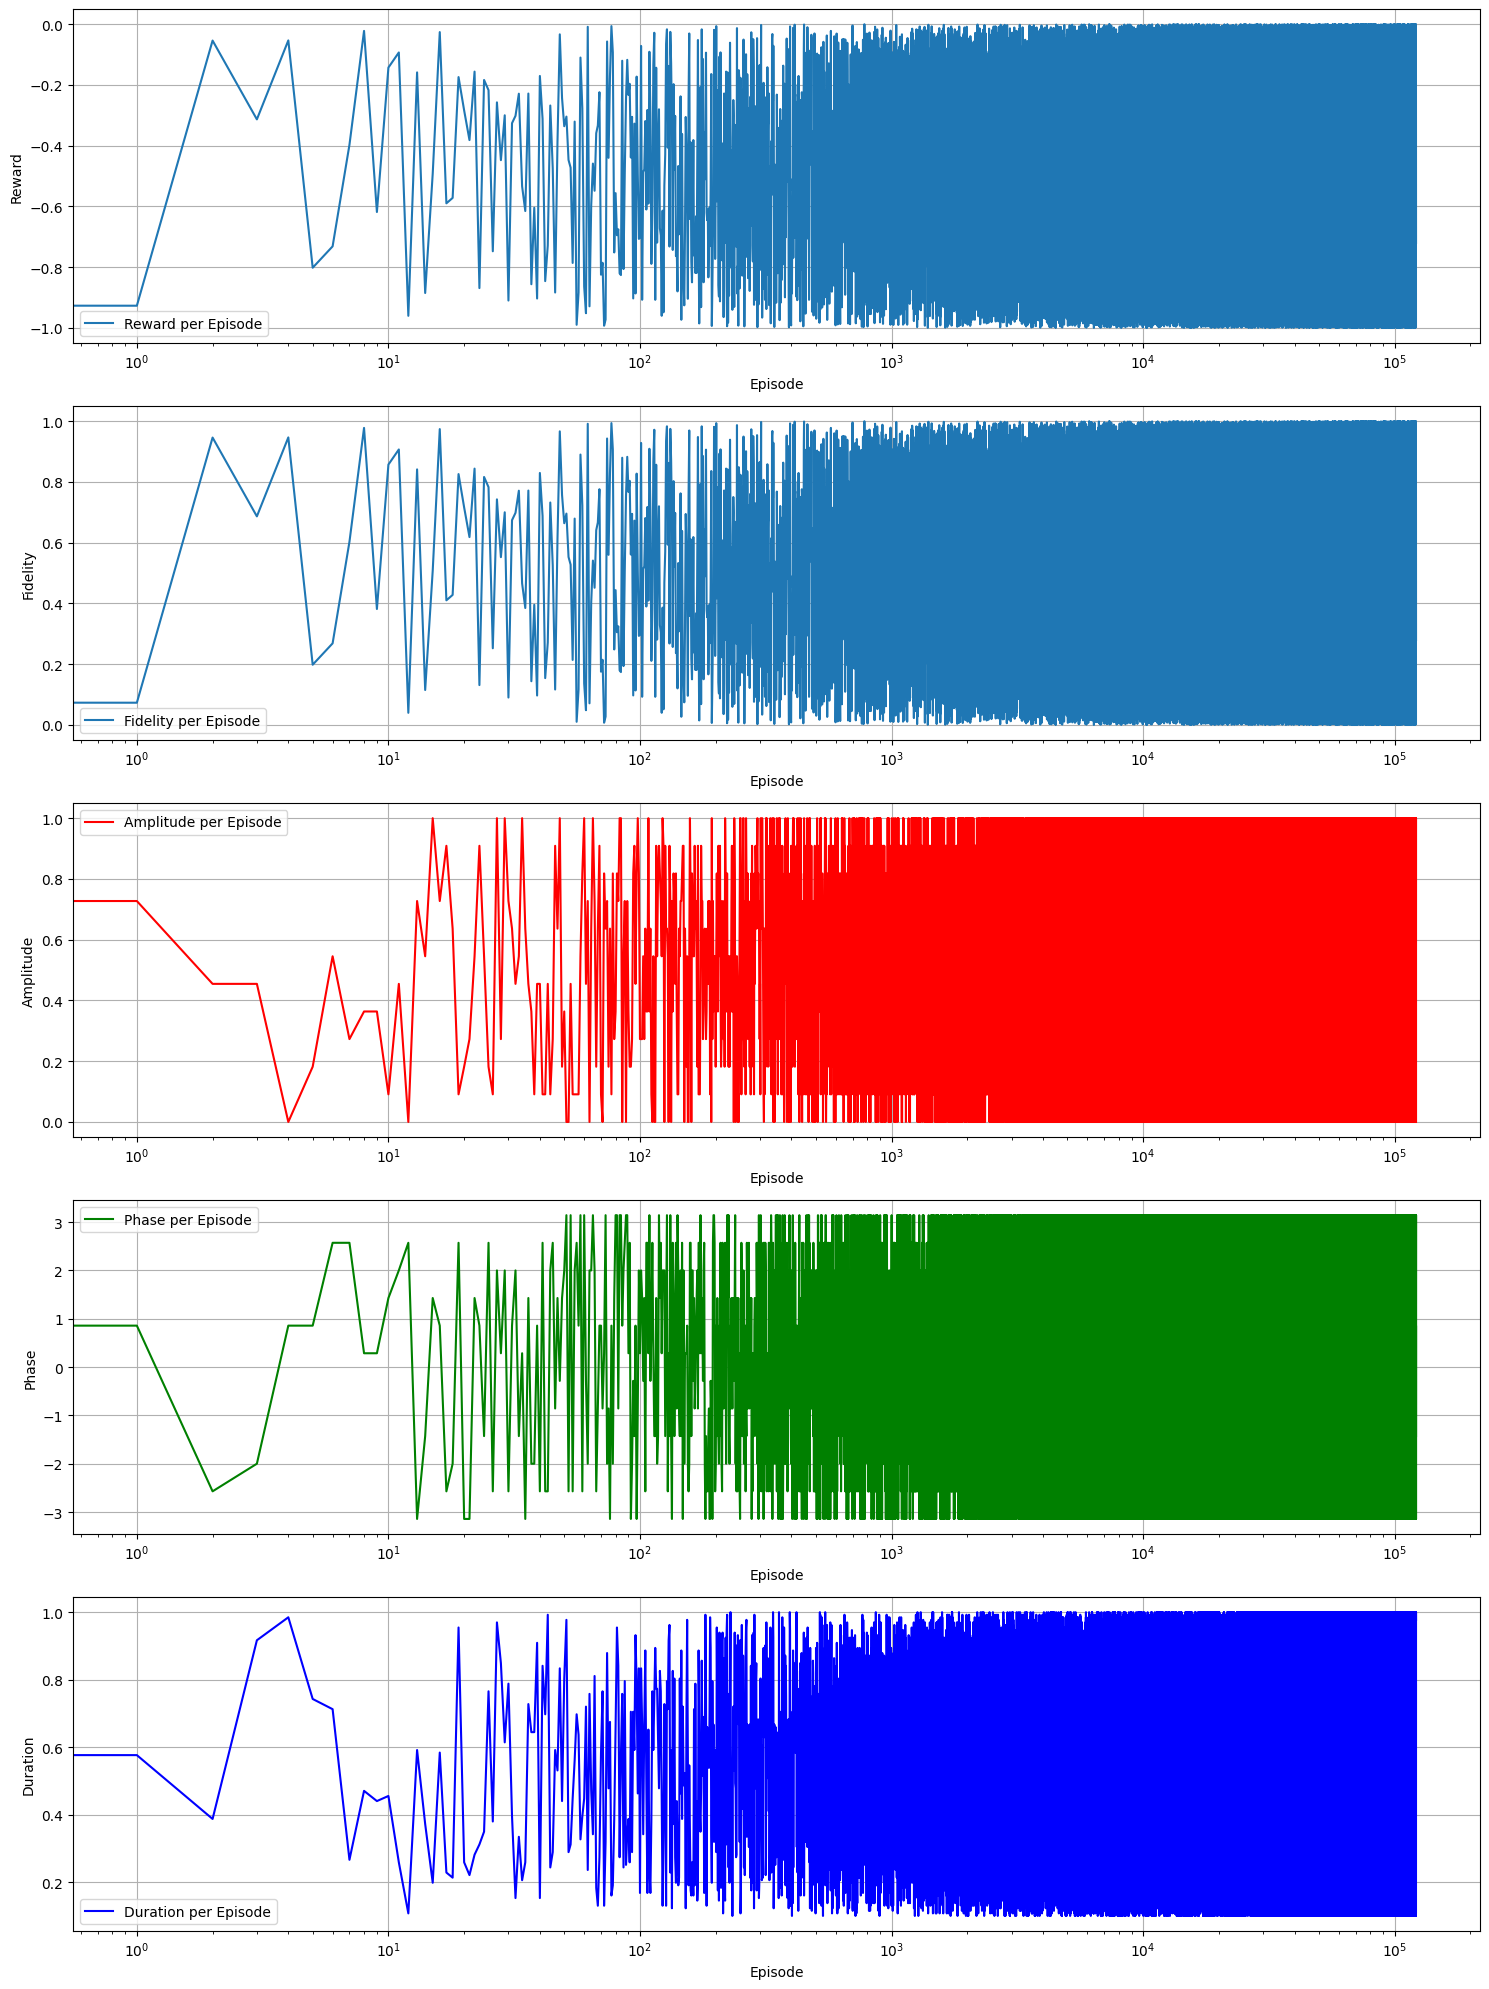

In [20]:
# Plot Results
plot_results(
    reward_history,
    fidelity_history,
    amplitudes_history,
    phases_history,
    durations_history,
    False,
)

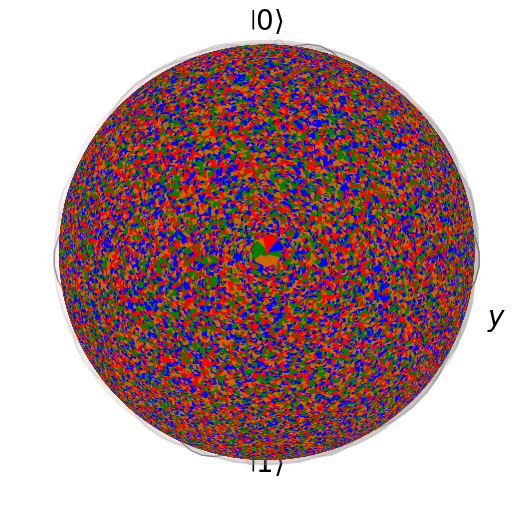

In [21]:
# Plot Bloch Sphere
plot_bloch_sphere_trajectory(state_history)

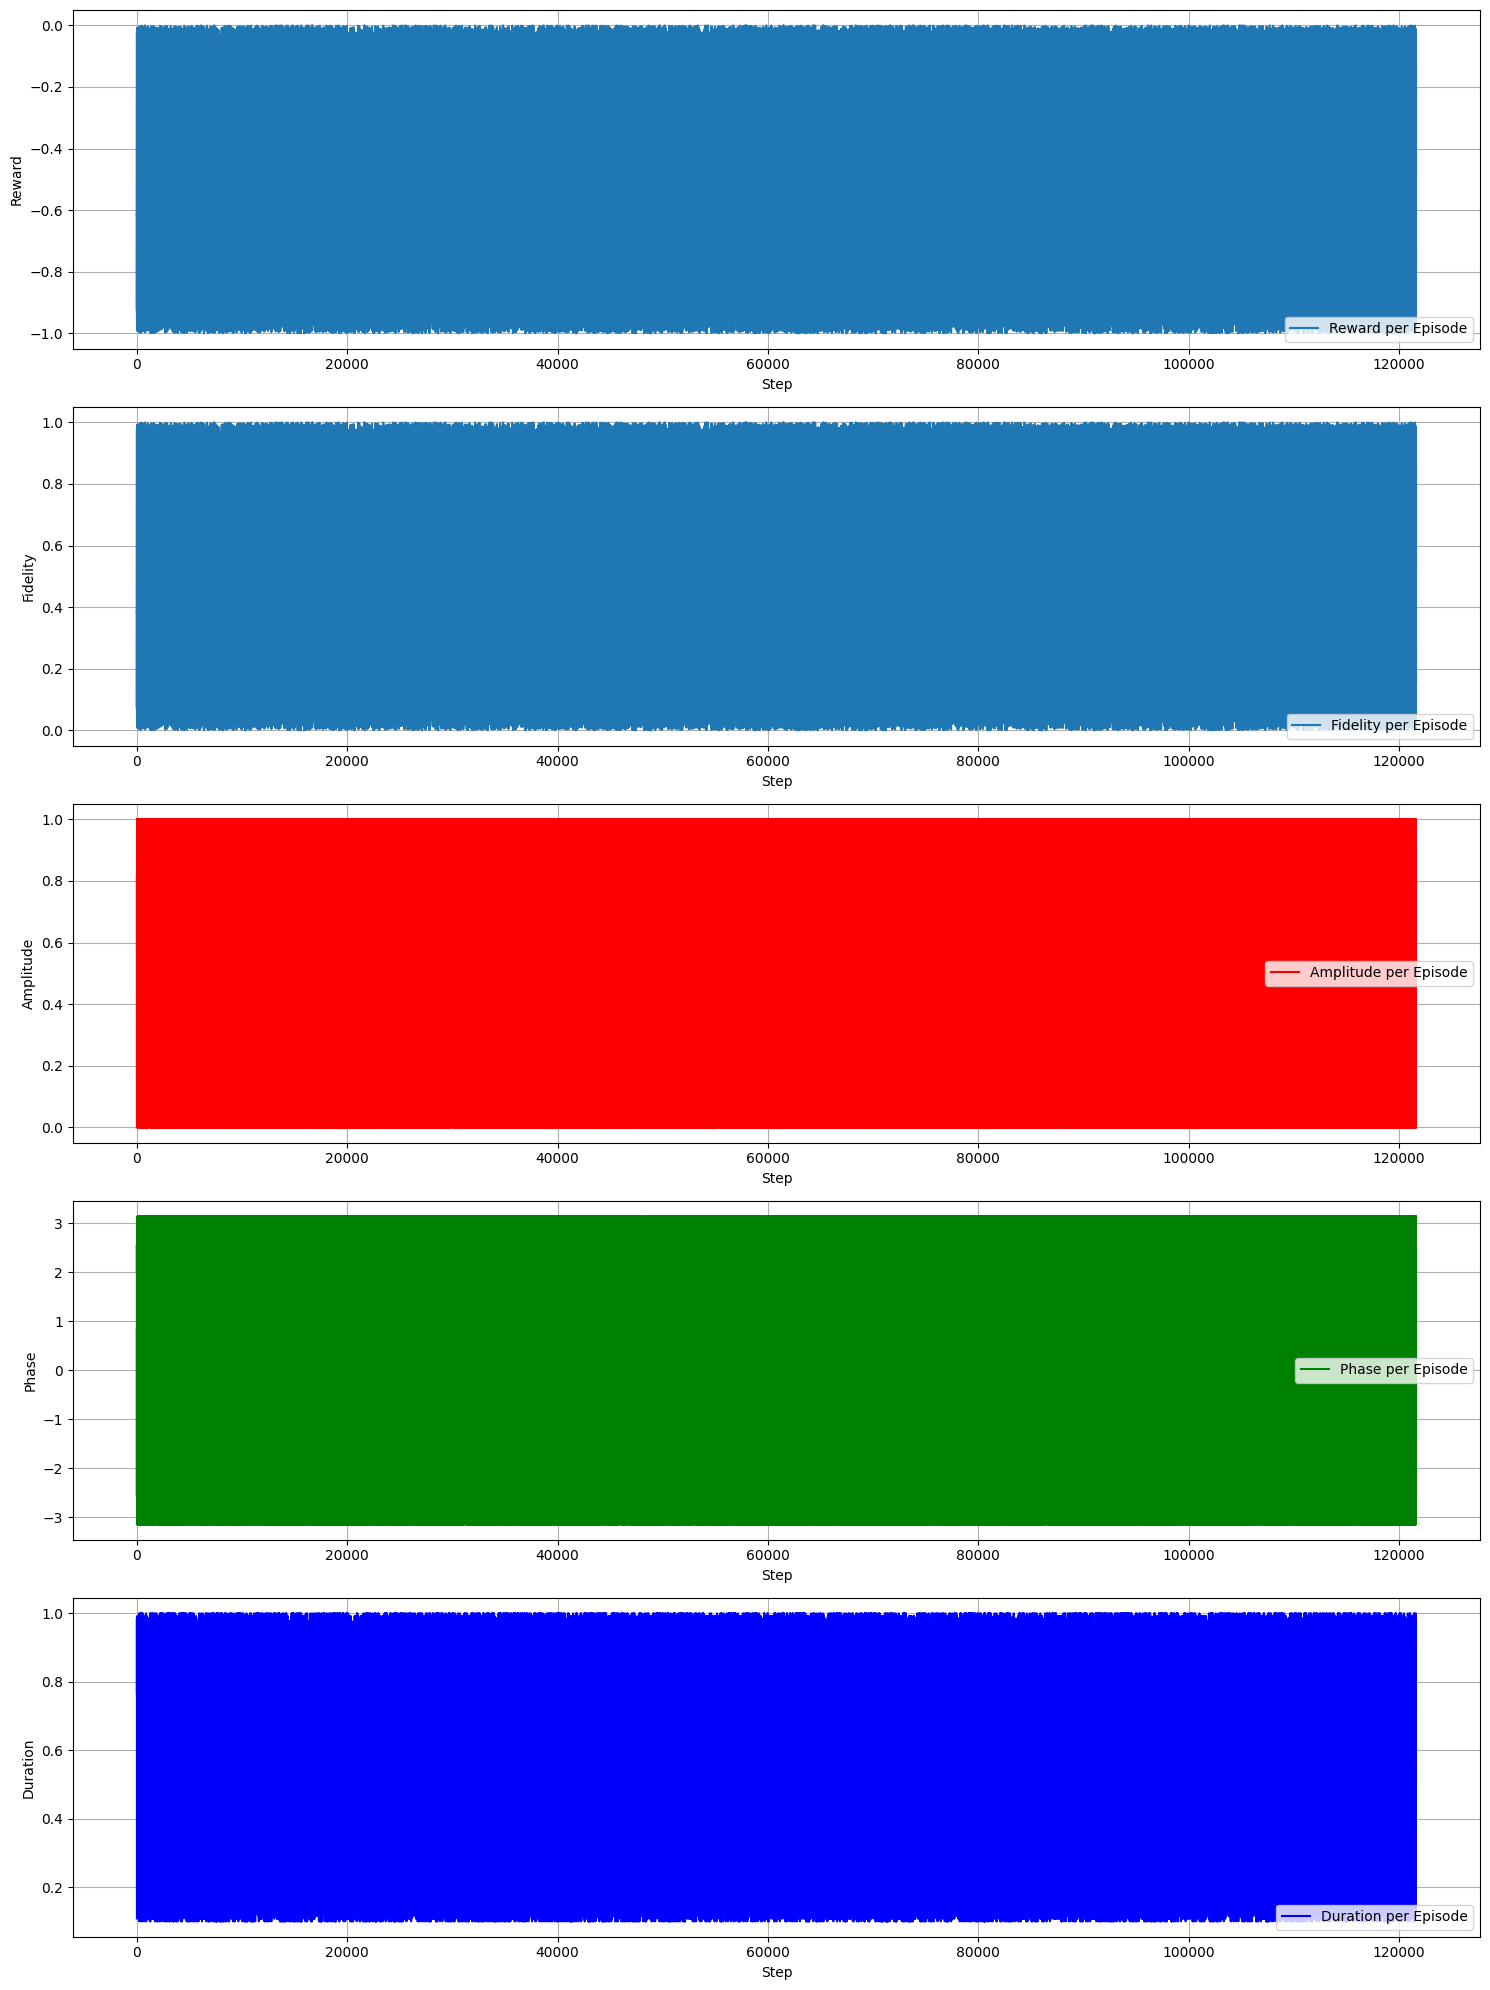

In [22]:
plot_results(
    reward_history,
    fidelity_history,
    amplitudes_history,
    phases_history,
    durations_history,
    True,
)

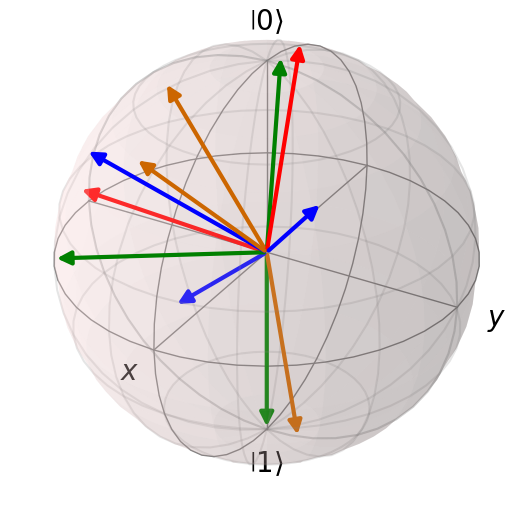

In [23]:
plot_bloch_sphere_trajectory(env.state_episode)

T-Gate

In [24]:
env = QuantumGateEnv(gate="T")
agent = PPOAgent(env.state_size, env.action_size)

if torch.__version__ >= "2.0.0":
    agent.network = torch.compile(agent.network)

(
    reward_history,
    fidelity_history,
    state_history,
    amplitudes_history,
    phases_history,
    durations_history,
) = train_agent(agent, env, EPISODES, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.83863, Fidelity: 0.16137
Episode: 2000/200000,  Reward: -0.05109, Fidelity: 0.94891
Episode: 4000/200000,  Reward: -0.46955, Fidelity: 0.53045
Episode: 6000/200000,  Reward: -0.48294, Fidelity: 0.51706
Episode: 8000/200000,  Reward: -0.05114, Fidelity: 0.94886
Episode: 10000/200000,  Reward: -0.04715, Fidelity: 0.95285
Episode: 12000/200000,  Reward: -0.24109, Fidelity: 0.75891
Episode: 14000/200000,  Reward: -0.35829, Fidelity: 0.64171
Episode: 16000/200000,  Reward: -0.36627, Fidelity: 0.63373
Episode: 18000/200000,  Reward: -0.30333, Fidelity: 0.69667
Early stopping triggered. Achieved fidelity: 1.00000, Episode: 19385, Patience: 0, Reward: -0.00000
Training finished.


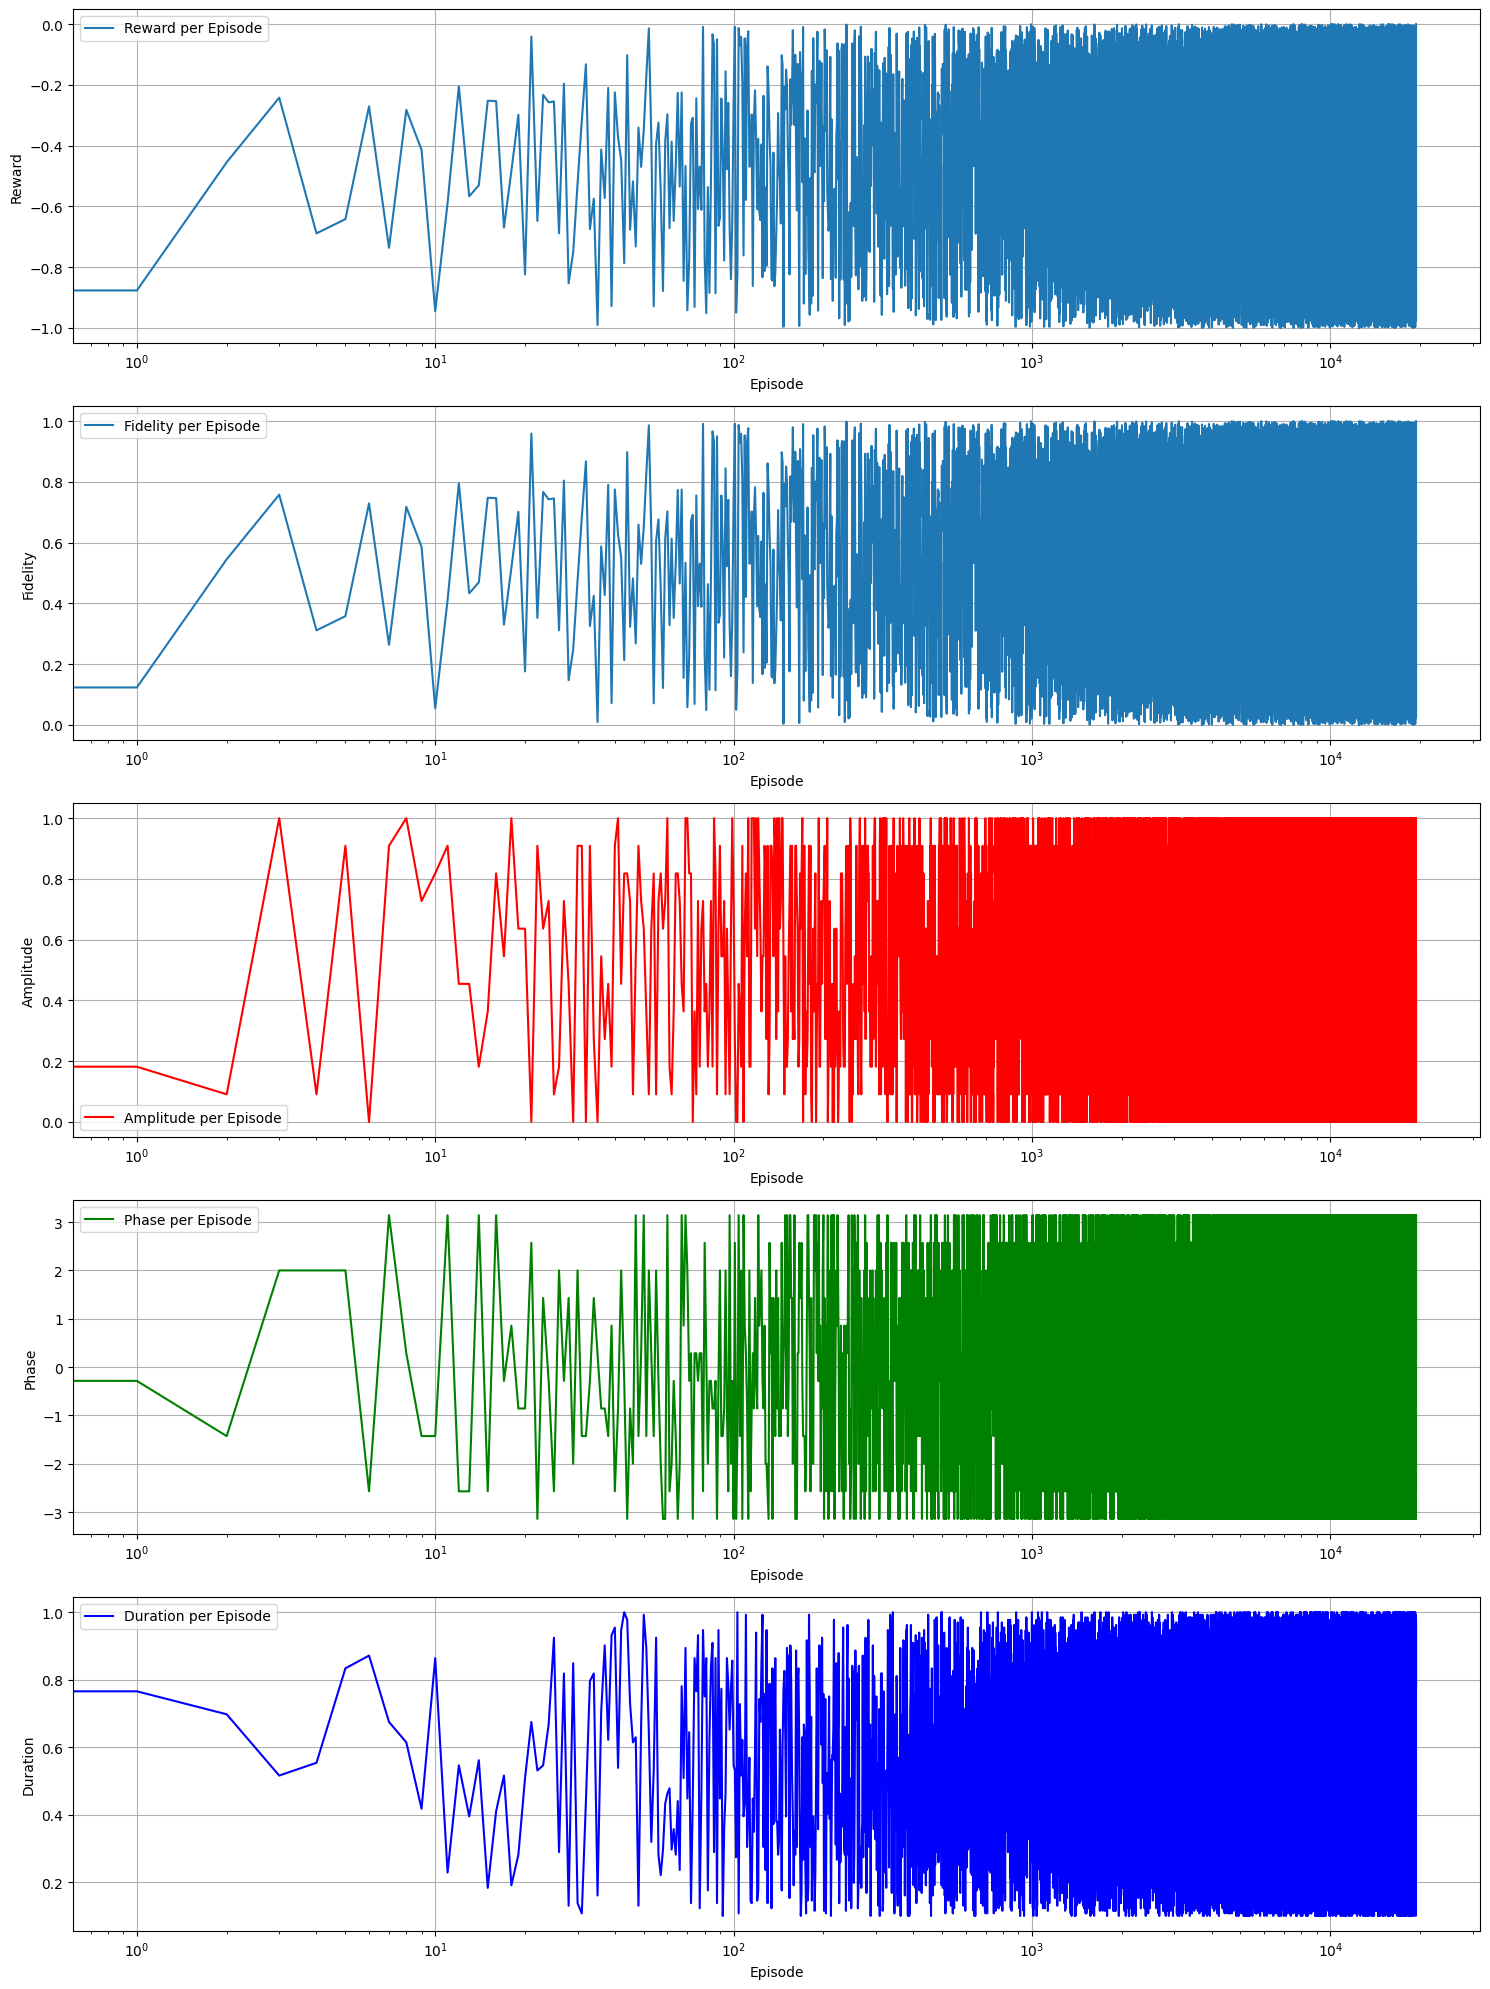

In [26]:
# Plot Results
plot_results(
    reward_history,
    fidelity_history,
    amplitudes_history,
    phases_history,
    durations_history,
    False,
)

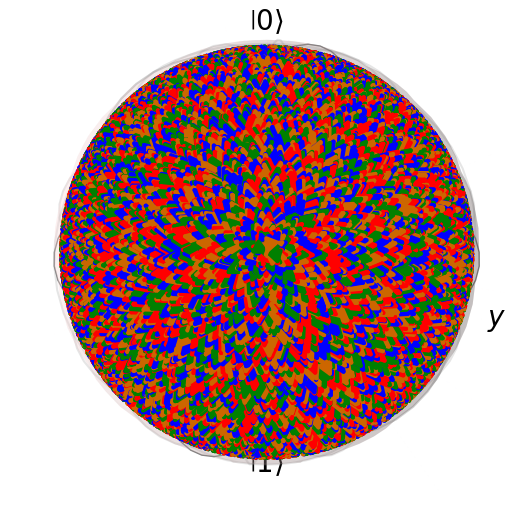

In [27]:
# Plot Bloch Sphere
plot_bloch_sphere_trajectory(state_history)

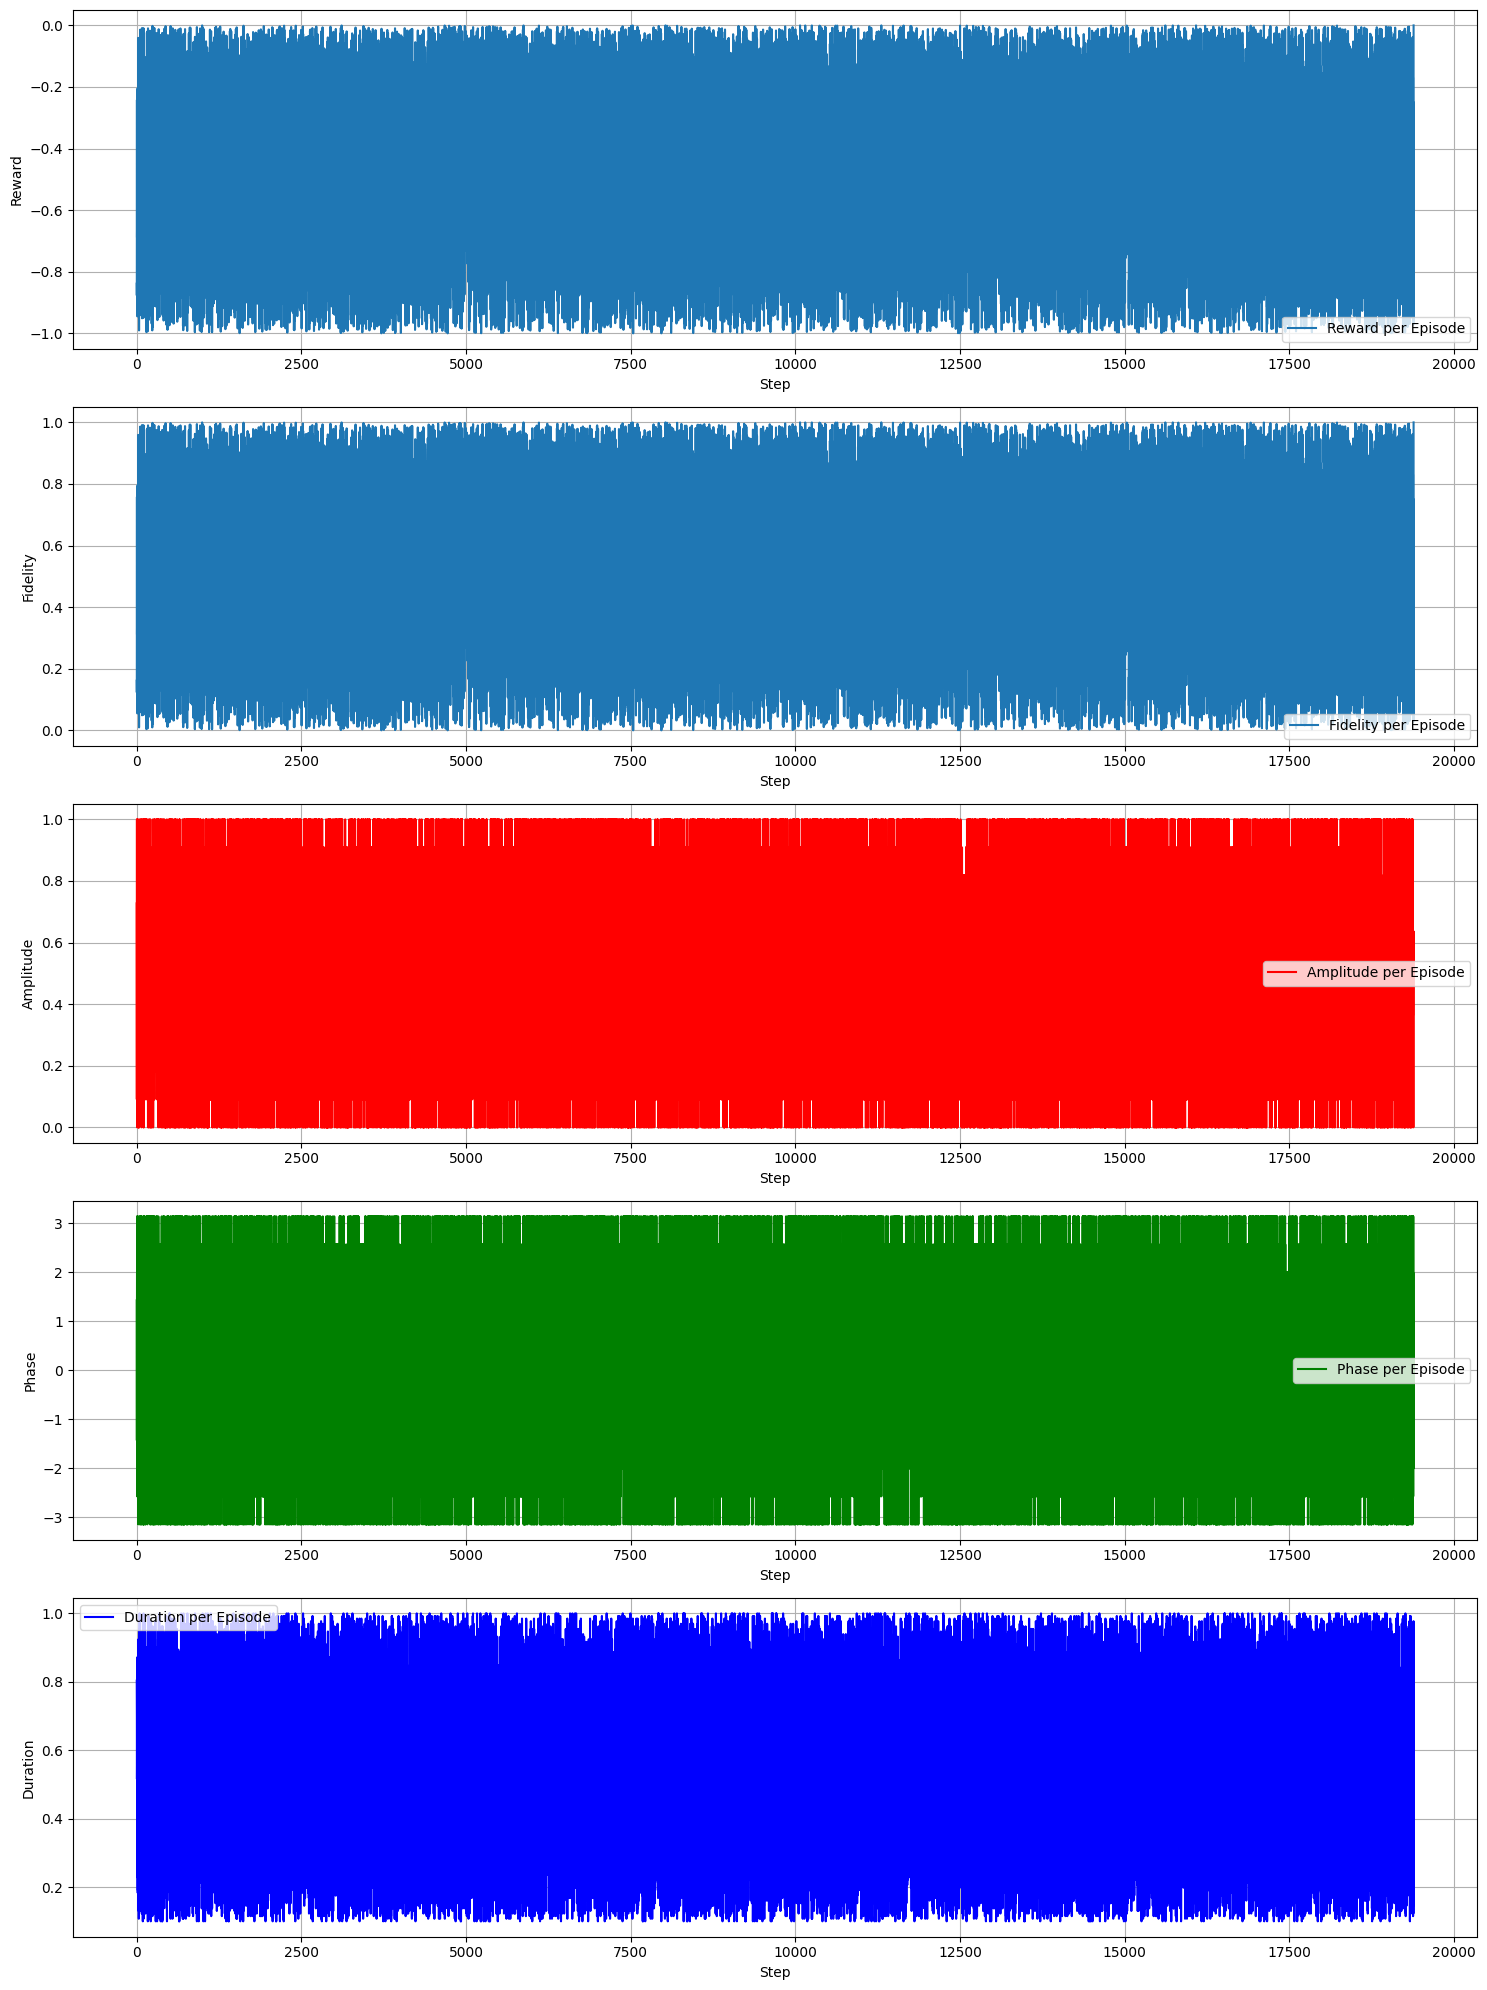

In [28]:
plot_results(
    reward_history,
    fidelity_history,
    amplitudes_history,
    phases_history,
    durations_history,
    True,
)

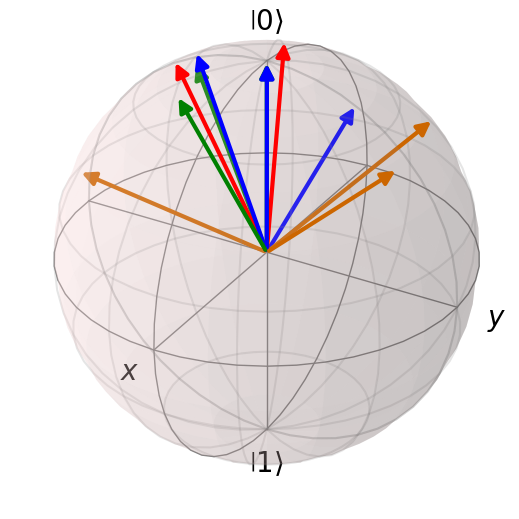

In [29]:
plot_bloch_sphere_trajectory(env.state_episode)

CNOT-Gate

In [30]:
env = QuantumGateEnv(gate="CNOT")
agent = PPOAgent(env.state_size, env.action_size)

if torch.__version__ >= "2.0.0":
    agent.network = torch.compile(agent.network)

(
    reward_history,
    fidelity_history,
    state_history,
    amplitudes_history,
    phases_history,
    durations_history,
) = train_agent(agent, env, EPISODES, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.77299, Fidelity: 0.22701
Episode: 2000/200000,  Reward: -0.74129, Fidelity: 0.25871
Episode: 4000/200000,  Reward: -0.14983, Fidelity: 0.85017
Episode: 6000/200000,  Reward: -0.45822, Fidelity: 0.54178
Episode: 8000/200000,  Reward: -0.68251, Fidelity: 0.31749
Episode: 10000/200000,  Reward: -0.30999, Fidelity: 0.69001
Episode: 12000/200000,  Reward: -0.67921, Fidelity: 0.32079
Episode: 14000/200000,  Reward: -0.27030, Fidelity: 0.72970
Episode: 16000/200000,  Reward: -0.13065, Fidelity: 0.86935
Episode: 18000/200000,  Reward: -0.44921, Fidelity: 0.55079
Episode: 20000/200000,  Reward: -0.90345, Fidelity: 0.09655
Episode: 22000/200000,  Reward: -0.45016, Fidelity: 0.54984
Episode: 24000/200000,  Reward: -0.23780, Fidelity: 0.76220
Episode: 26000/200000,  Reward: -0.67997, Fidelity: 0.32003
Episode: 28000/200000,  Reward: -0.98229, Fidelity: 0.01771
Episode: 30000/200000,  Reward: -0.13784, Fidelity: 0.86216
Episode: 32000/200000,  Reward: -0.09281, Fideli

In [31]:
def plot_q_sphere(states):
    """
    Plot the QSphere for a list of quantum states.

    Parameters:
    states: list of quantum states in the form of complex-valued numpy arrays
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Draw the QSphere (Bloch sphere)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color="r", alpha=0.1)

    # Plot the initial state with a distinct color
    initial_state = states[0]
    alpha_init = initial_state[0]
    beta_init = initial_state[1]

    theta_init = 2 * np.arccos(np.abs(alpha_init))  # Polar angle
    phi_init = np.angle(beta_init) - np.angle(alpha_init)  # Azimuthal angle

    x_init = np.sin(theta_init) * np.cos(phi_init)
    y_init = np.sin(theta_init) * np.sin(phi_init)
    z_init = np.cos(theta_init)

    ax.plot([0, x_init], [0, y_init], [0, z_init], color="black", linestyle="--")
    ax.scatter(x_init, y_init, z_init, color="black", s=100)

    # Plot the other states
    for state in states[1:]:
        alpha = state[0]
        beta = state[1]

        # Calculate spherical coordinates
        theta = 2 * np.arccos(np.abs(alpha))  # Polar angle
        phi = np.angle(beta) - np.angle(alpha)  # Azimuthal angle

        # Cartesian coordinates
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)

        # Color based on phase
        color = cm.hsv((phi + np.pi) / (2 * np.pi))

        ax.plot([0, x], [0, y], [0, z], color=color)
        ax.scatter(x, y, z, color=color, s=100)

    # Set axis limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # Set labels
    ax.set_xlabel("Re(α)")
    ax.set_ylabel("Im(α)")
    ax.set_zlabel("Re(β)")
    plt.show()

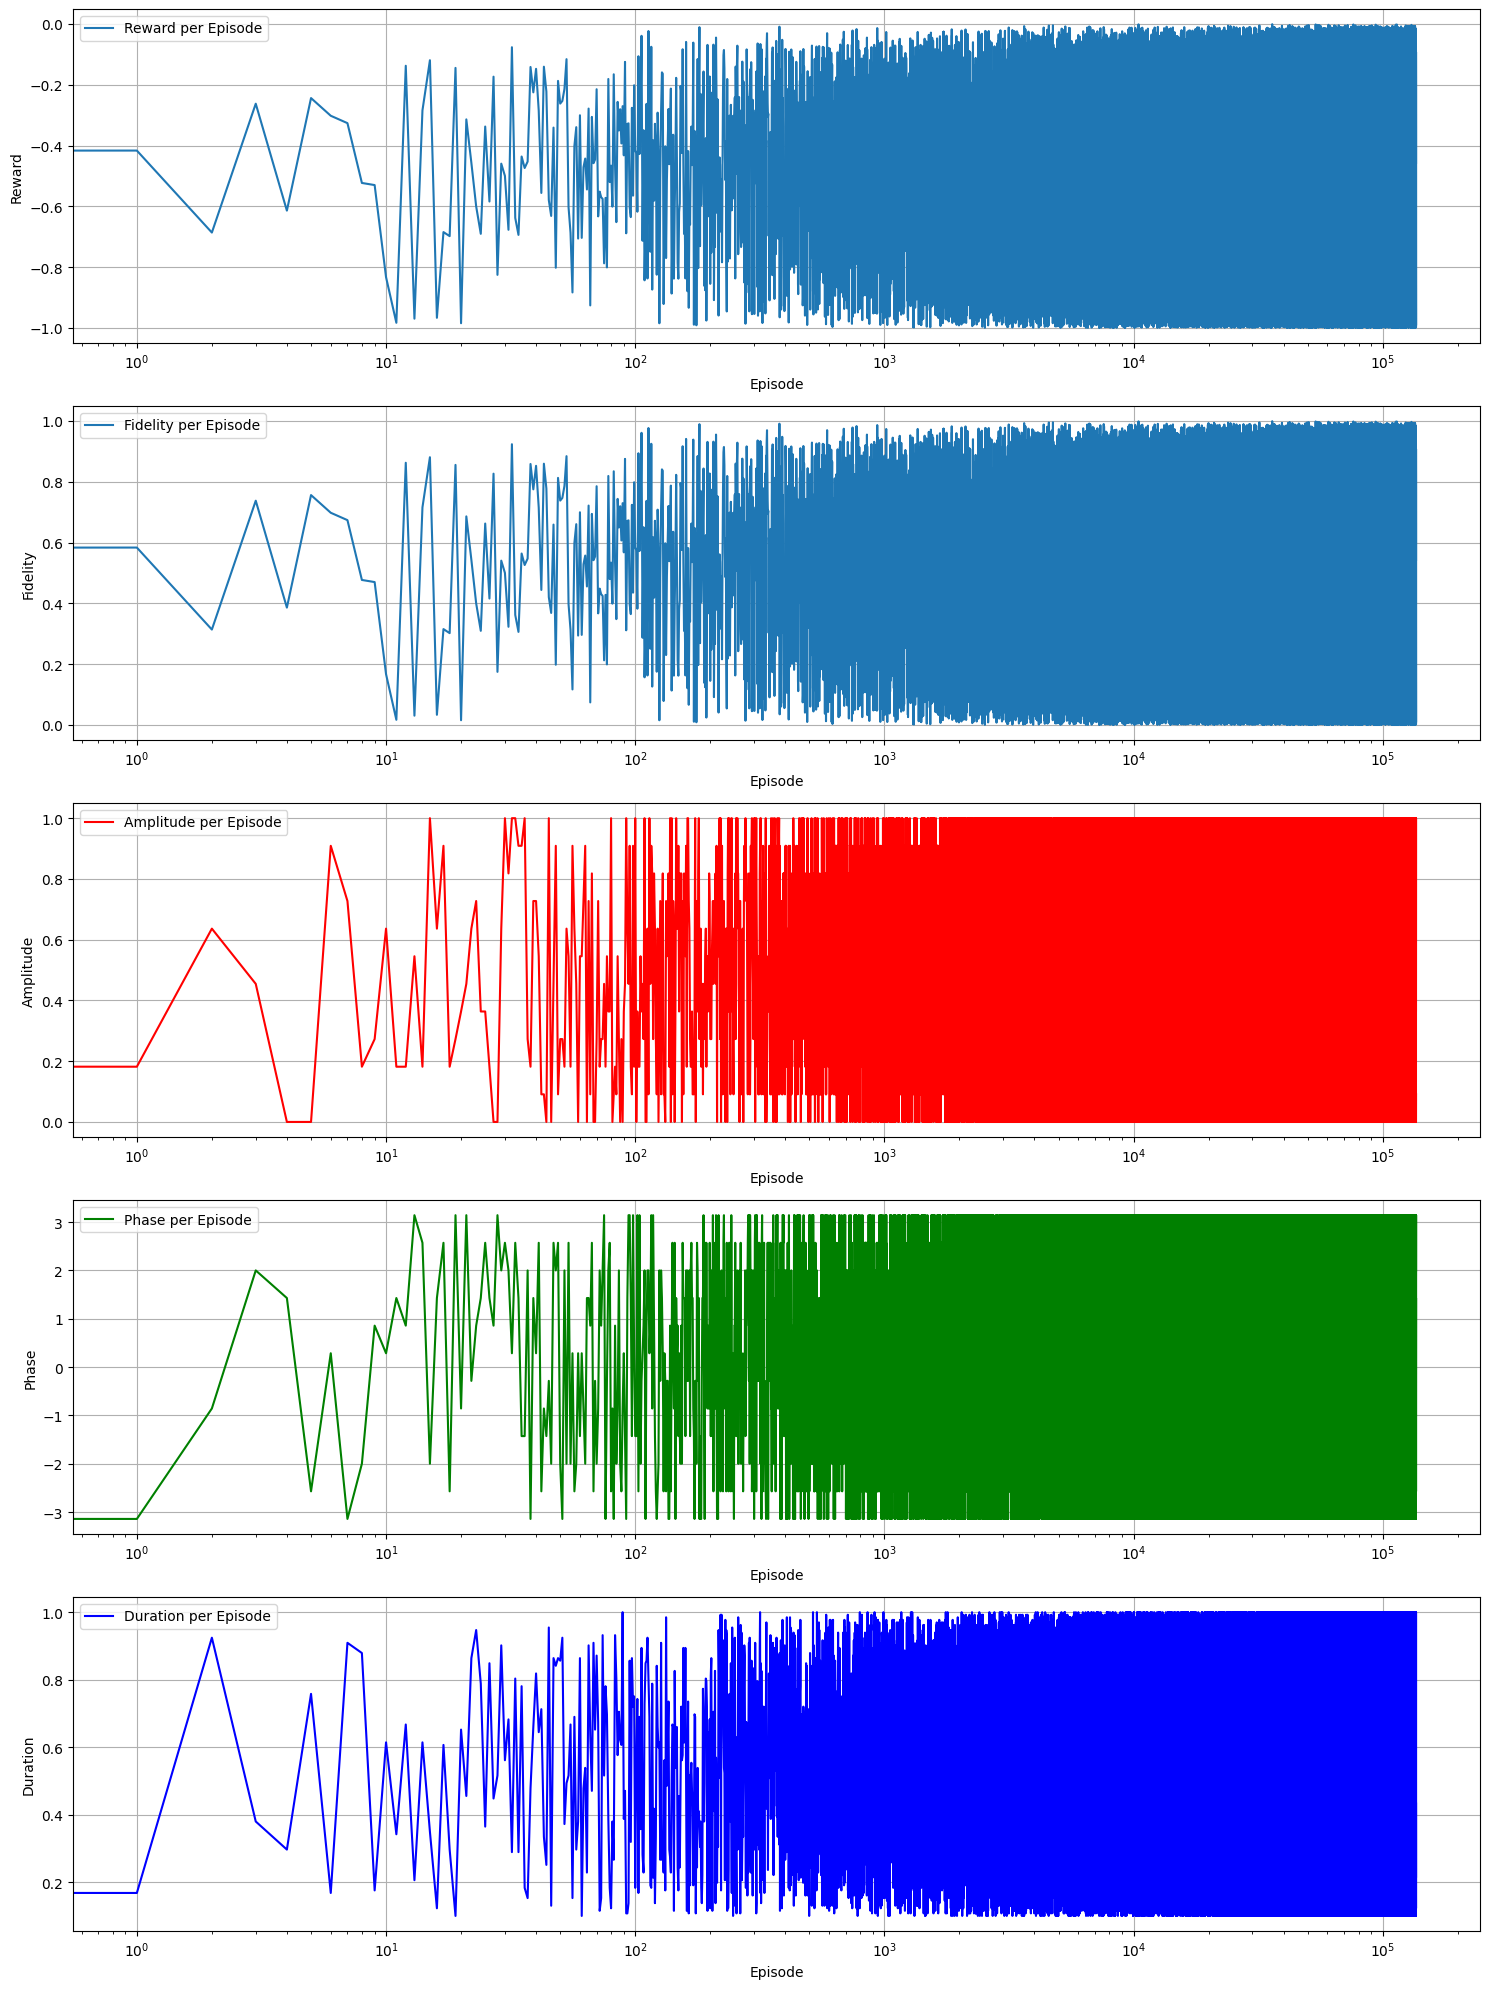

In [32]:
# Plot Results
plot_results(
    reward_history,
    fidelity_history,
    amplitudes_history,
    phases_history,
    durations_history,
    False,
)

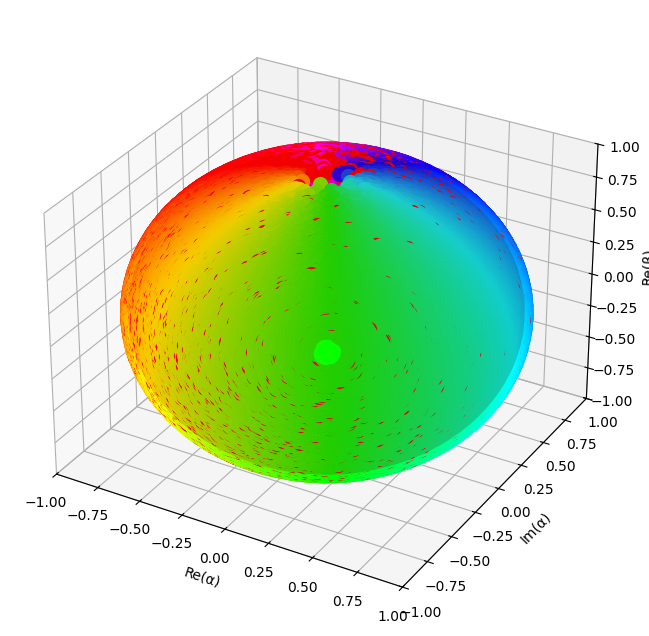

In [33]:
plot_q_sphere(state_history)

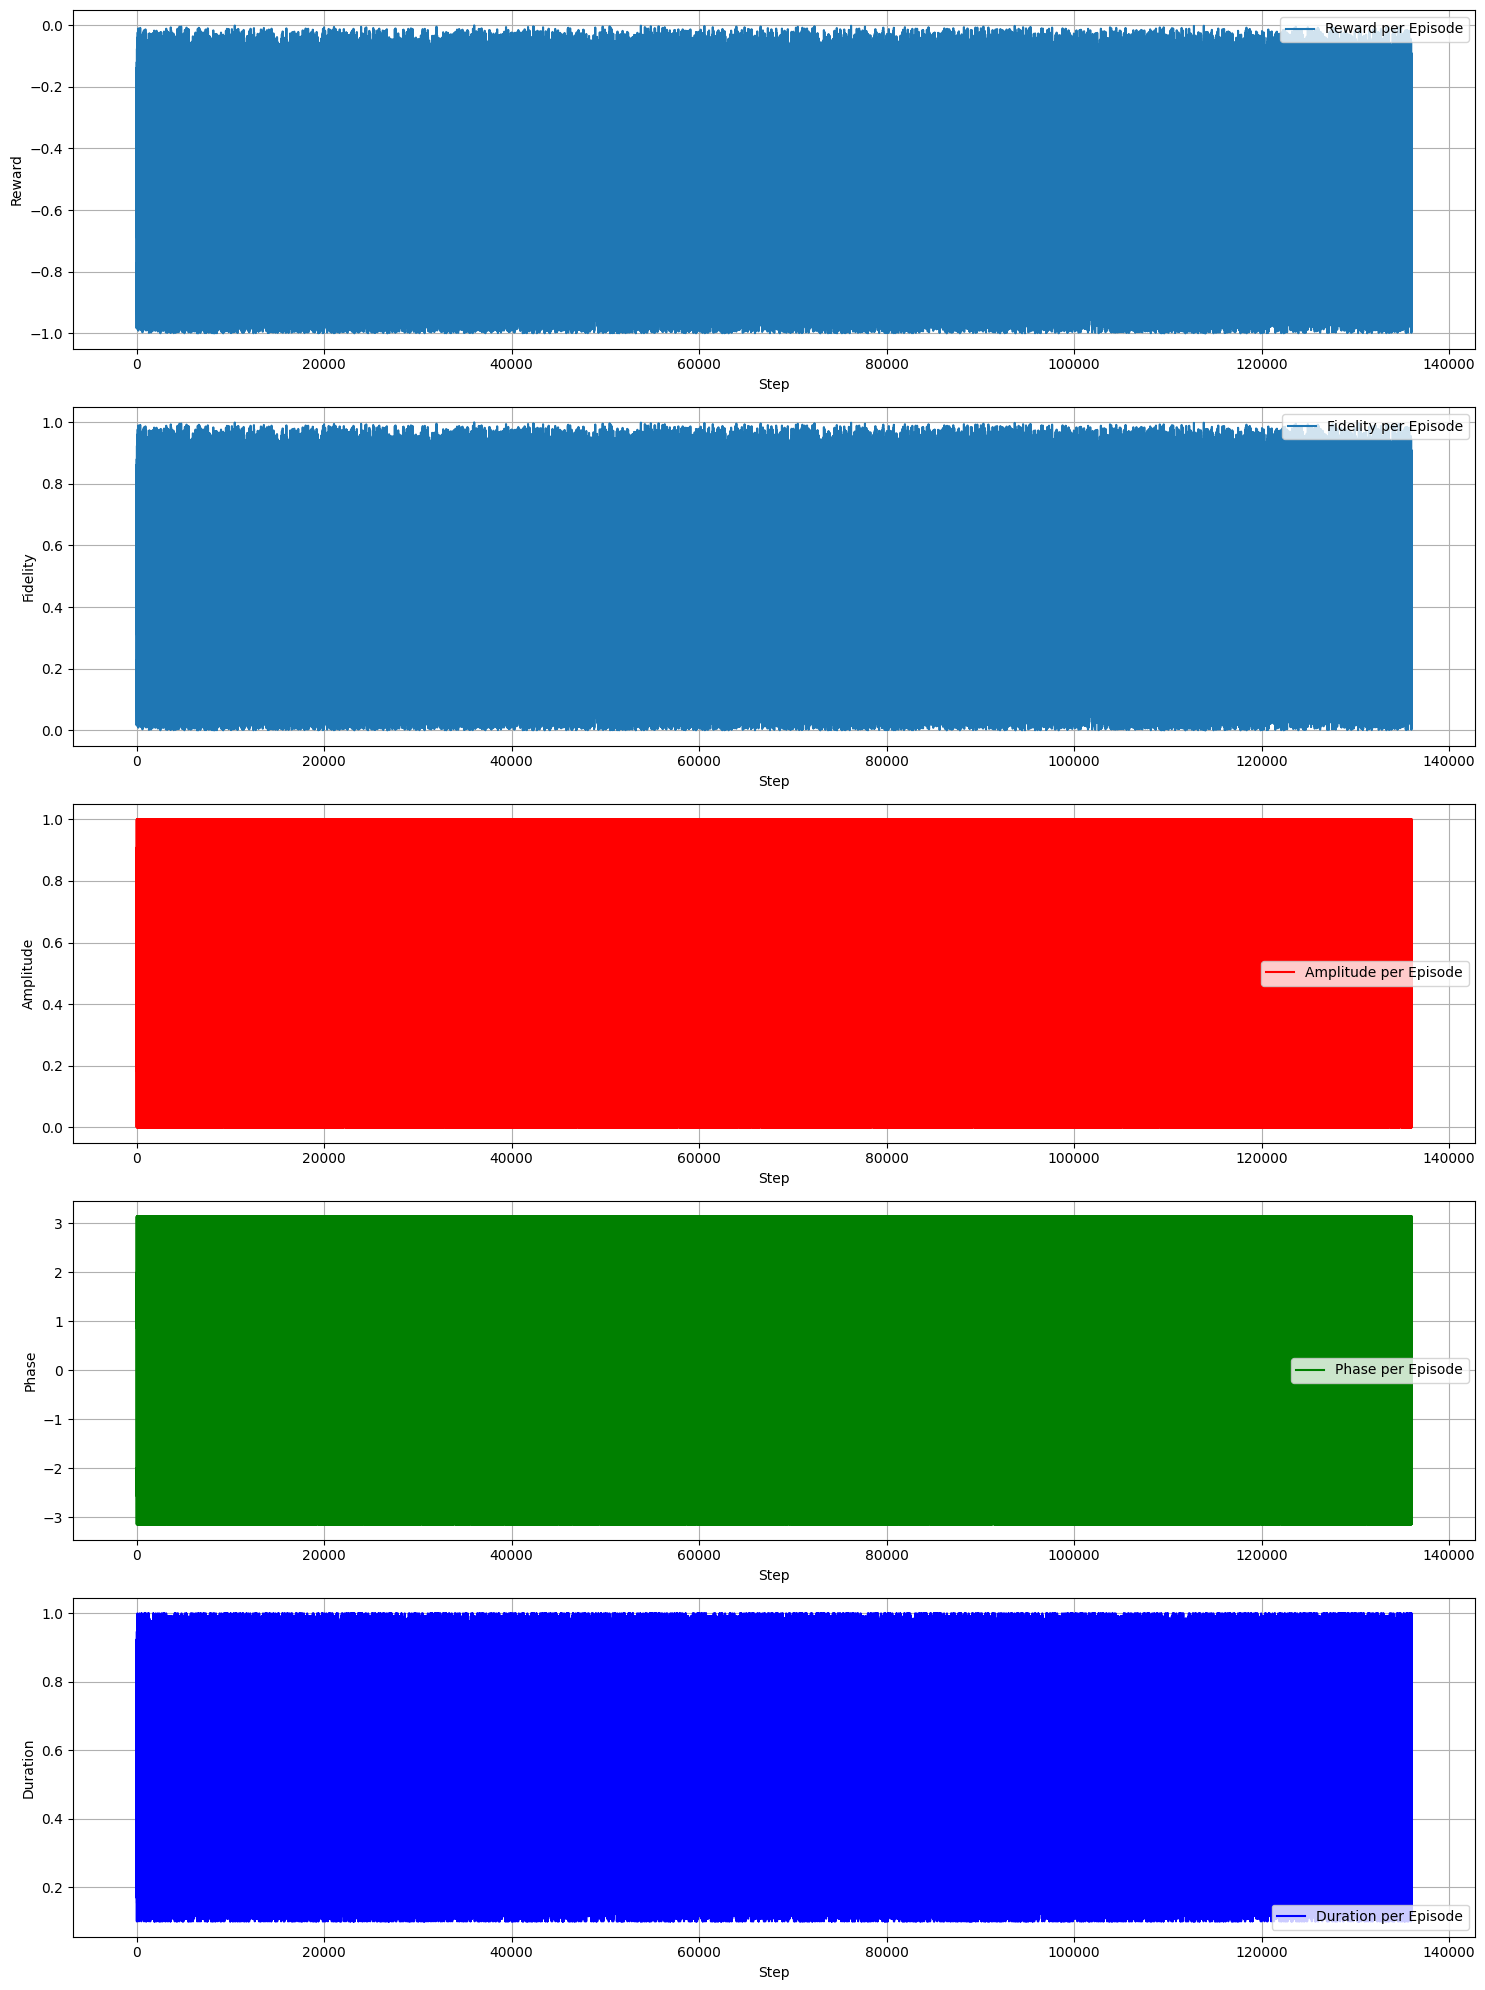

In [34]:
plot_results(
    reward_history,
    fidelity_history,
    amplitudes_history,
    phases_history,
    durations_history,
    True,
)

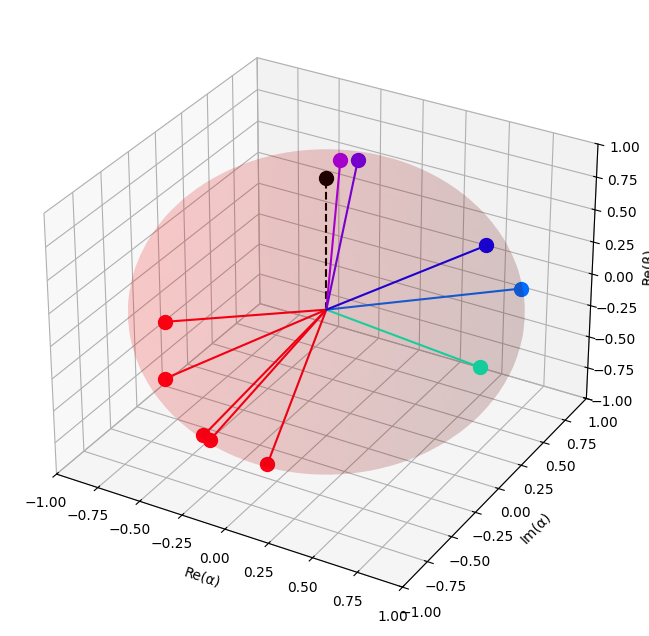

In [35]:
plot_q_sphere(env.state_episode)